In [1]:
# This notebook is similar to Example 7

In [2]:
# conda: gridTools

In [3]:
# We utilize the 20x30 example grid along the
# California coast.

In [4]:
import sys, os, logging
from gridtools.gridutils import GridUtils
from gridtools.datasource import DataSource
import pdb

import cartopy
import xarray as xr
%matplotlib inline

In [5]:
# Setup a work directory
#wrkDir = '/home/cermak/mom6/configs/zOutput'
wrkDir = '/import/AKWATERS/jrcermakiii/configs/zOutput'
inputDir = os.path.join(wrkDir, "INPUT")

In [6]:
# Initialize a grid object
grd = GridUtils()

In [7]:
# We can turn on extra output from the module
grd.printMsg("Setting print and logging messages to the DEBUG level.")
logFilename = os.path.join(wrkDir, 'LCC_20x30.log')
grd.setVerboseLevel(logging.DEBUG)
grd.setDebugLevel(0)
grd.setLogLevel(logging.DEBUG)
grd.deleteLogfile(logFilename)
grd.enableLogging(logFilename)

Setting print and logging messages to the DEBUG level.
New DEBUG level (0)
Logfile (/import/AKWATERS/jrcermakiii/configs/zOutput/LCC_20x30.log) removed.
Logging enabled


In [8]:
# Make sure we erase any previous grid, grid parameters and plot parameters.
grd.clearGrid()

# Specify the grid parameters
# gridMode should be 2.0 for supergrid
# Normally 30.0; 0.0 for debugging
gtilt = 30.0
grd.printMsg("Set grid parameters.")
grd.setGridParameters({
    'projection': {
        'name': 'LambertConformalConic',
        'lon_0': 230.0,
        'lat_0': 40.0,
        'ellps': 'WGS84'
    },
    'centerX': 230.0,
    'centerY': 40.0,
    'centerUnits': 'degrees',
    'dx': 20.0,
    'dxUnits': 'degrees',
    'dy': 30.0,
    'dyUnits': 'degrees',
    'tilt': gtilt,
    'gridResolutionX': 1.0,
    'gridResolutionY': 1.0,
    'gridResolution': 1.0,
    'gridResolutionXUnits': 'degrees',
    'gridResolutionYUnits': 'degrees',
    'gridResolutionUnits': 'degrees',
    'gridMode': 2,
    'gridType': 'MOM6',
    'ensureEvenI': True,
    'ensureEvenJ': True,
    'tileName': 'tile1',
})
grd.printMsg("")

Set grid parameters.



In [9]:
# This forms a grid in memory using the specified grid parameters
grd.makeGrid()
grd.printMsg("")

Generating regular lat-lon grid centered at (230.00, 0.00) on equator.
   Generated regular lat-lon grid between latitudes -15.00 15.00
   Number of js=61



In [10]:
# External data sources are required
# This creates an empty data source catalog
ds = DataSource()

# Connect the catalog to the grid object
grd.useDataSource(ds)

# For variableMap, matching variable values will be renamed to the
# variable key.  For evalMap, variables in the expression need
# to be in brackets.  If the key is new, a new field will be
# created with the given expression.
ds.addDataSource({
    'GEBCO_2020': {
            'url' : 'file:/import/AKWATERS/jrcermakiii/bathy/gebco/GEBCO_2020.nc',
            'variableMap' : {
                    'lat': 'lat',
                    'lon': 'lon',
                    'depth' : 'elevation'
                },
            'evalMap': {
                    'depth' : '-[depth]'
                }
        }
})


In [11]:
# Save the catalog just for demonstration
ds.saveCatalog(os.path.join(wrkDir, 'catalog.json'))
ds.saveCatalog(os.path.join(wrkDir, 'catalog.yaml'))

In [12]:
# We do not need to compute bathymetric roughness if we have an existing file
# Increase the memory footprint (maxMb) to allow more mesh refinements to
# be used from the topography.
bathyGridFilename = os.path.join(wrkDir, 'ocean_topog_Example7.nc')

if os.path.isfile(bathyGridFilename):
    bathyGrids = xr.open_dataset(bathyGridFilename)
else:
    # Data sources cannot be in chunked mode for use in this routine
    bathyGrids = grd.computeBathymetricRoughness('ds:GEBCO_2020',
            maxMb=99, superGrid=False, useClipping=False,
            FixByOverlapQHGridShift=True,
            auxVariables=['hStd', 'hMin', 'hMax', 'depth'],
    )

    # This is needed to really convert the elevation field to depth
    # The 'depth' field has to be requested as an auxVariables
    grd.applyEvalMap('ds:GEBCO_2020', bathyGrids)
    
    # Apply existing land mask which should not change anything
    # The minimum depth will modify a couple points.   We save the
    # new field as 'newDepth' to allow comparison with 'depth'.
    bathyGrids['newDepth'] = grd.applyExistingLandmask(bathyGrids, 'depth',
            os.path.join(wrkDir, 'land_mask_Example7.nc'), 'mask',
            MASKING_DEPTH=0.0, MINIMUM_DEPTH=1000.0, MAXIMUM_DEPTH=-99999.0)
    bathyGrids['newDepth'].attrs['units'] = 'meters'
    bathyGrids['newDepth'].attrs['standard_name'] = 'topographic depth at Arakawa C h-points'

    # Write grid variables out to a file
    # TODO: provide a data source service hook?
    bathyGrids.to_netcdf(os.path.join(wrkDir, 'ocean_topog_Example7.nc'),
            encoding=grd.removeFillValueAttributes(data=bathyGrids))

In [13]:
grd.saveGrid(filename=os.path.join(wrkDir, "LCC_20x30_Example7.nc"))

Successfully wrote netCDF file to /import/AKWATERS/jrcermakiii/configs/zOutput/LCC_20x30_Example7.nc


In [14]:
# Write out FMS related support files
grd.makeSoloMosaic(
    topographyGrid=bathyGrids['newDepth'],
    writeLandmask=True,
    writeOceanmask=True,
    inputDirectory=inputDir,
    overwrite=True,
)
grd.saveGrid(filename=os.path.join(inputDir, "ocean_hgrid.nc"))

Successfully wrote netCDF file to /import/AKWATERS/jrcermakiii/configs/zOutput/INPUT/ocean_hgrid.nc


In [15]:
# Do some plotting!

In [16]:
# Set plot parameters for the grid and topography

grd.setPlotParameters(
    {
        'figsize': (8,8),
        'projection': {
            'name': 'NearsidePerspective',
            'lat_0': 40.0,
            'lon_0': 230.0
        },
        'extent': [-160.0 ,-100.0, 20.0, 60.0],
        'iLinewidth': 1.0,
        'jLinewidth': 1.0,
        'showGridCells': False,
        'title': "Nearside Perspective: 20x30 with %.1f degree tilt" % (gtilt),
        'iColor': 'k',
        'jColor': 'k',
        'transform': cartopy.crs.PlateCarree(),
        'satellite_height': 35785831.0,
    }
)

In [17]:
# Show the model grid only
grd.setPlotParameters({'showGridCells': False})
(figure, axes) = grd.plotGrid()

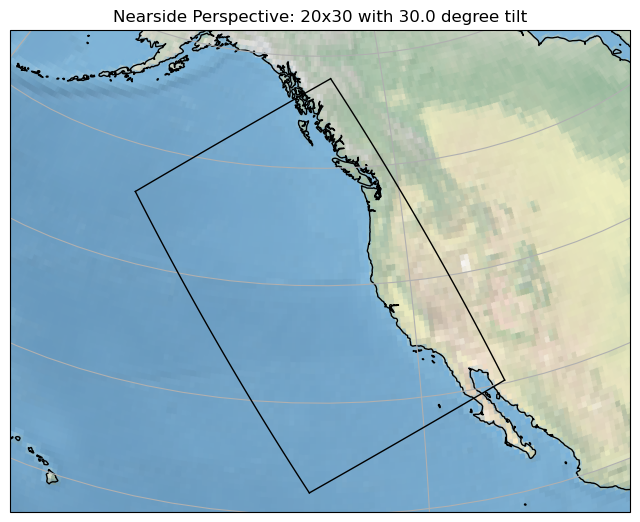

In [18]:
figure

In [19]:
figure.savefig(os.path.join(wrkDir, 'LCC_20x30_ModelGrid.png'), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', transparent=False, bbox_inches=None, pad_inches=0.1)

In [20]:
# Show the model grid cells
grd.setPlotParameters({'showGridCells': True})
(figure, axes) = grd.plotGrid()

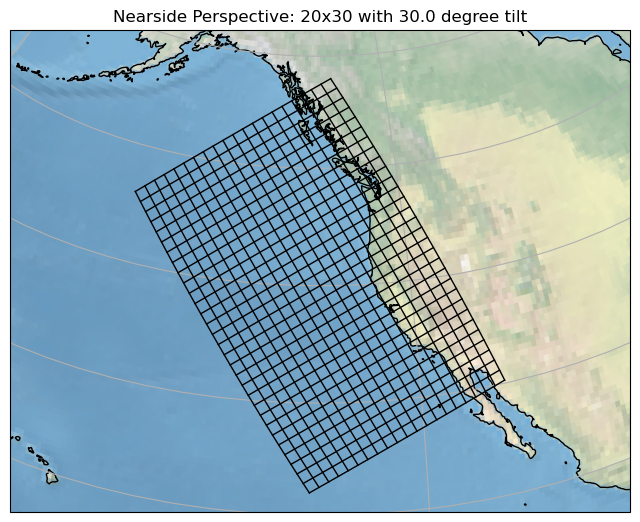

In [21]:
figure

In [22]:
figure.savefig(os.path.join(wrkDir, 'LCC_20x30_ModelGridCells.png'), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', transparent=False, bbox_inches=None, pad_inches=0.1)

In [23]:
# Show the model grid cells (TODO: Future feature)
# grd.setPlotParameters({'showSupergrid': True, 'showGridCells': False})
# (figure, axes) = grd.plotGrid()

In [24]:
#figure

In [25]:
#figure.savefig(os.path.join(wrkDir, 'LCC_20x30_ModelSupergrid.png'), dpi=None, facecolor='w', edgecolor='w',
#        orientation='landscape', transparent=False, bbox_inches=None, pad_inches=0.1)

In [26]:
# Plot original depth grid after running computeBathyRoughness()
(figure, axes) = grd.plotGrid(
    showModelGrid=False,
    plotVariables={
        'depth': {
            'values': bathyGrids['depth'],
            'title': 'Original diagnosed bathymetric field',
            'cbar_kwargs': {
                'orientation': 'horizontal',
            }
        }
    },
)

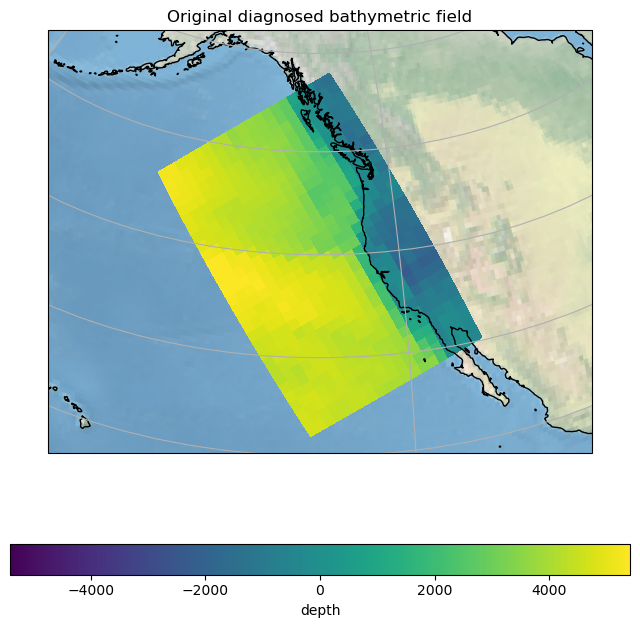

In [27]:
figure

In [28]:
figure.savefig(os.path.join(wrkDir, 'LCC_20x30_OrigBathy.png'), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', transparent=False, bbox_inches=None, pad_inches=0.1)

In [29]:
# Plot depth grid after we apply an existing landmask with minimum
# depth set to 1000 meters
(figure, axes) = grd.plotGrid(
    showModelGrid=False,
    plotVariables={
        'depth': {
            'values': bathyGrids['newDepth'],
            'title': 'Bathymetric grid with 1000 meter minimum depth',
            'cbar_kwargs': {
                'orientation': 'horizontal',
            }
        }
    },
)

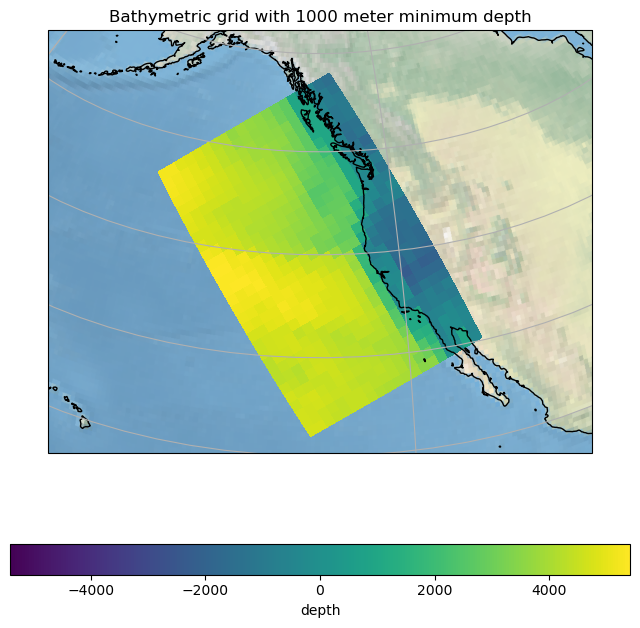

In [30]:
figure

In [31]:
figure.savefig(os.path.join(wrkDir, 'LCC_20x30_MinBathy.png'), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', transparent=False, bbox_inches=None, pad_inches=0.1)

In [32]:
# Show h2 diagnosed parameter
(figure, axes) = grd.plotGrid(
    showModelGrid=False,
    plotVariables={
        'h2': {
            'values': bathyGrids['h2'],
            'title': 'Bathymetric roughness (h2)',
            'cbar_kwargs': {
                'orientation': 'horizontal',
            }
        }
    },
)

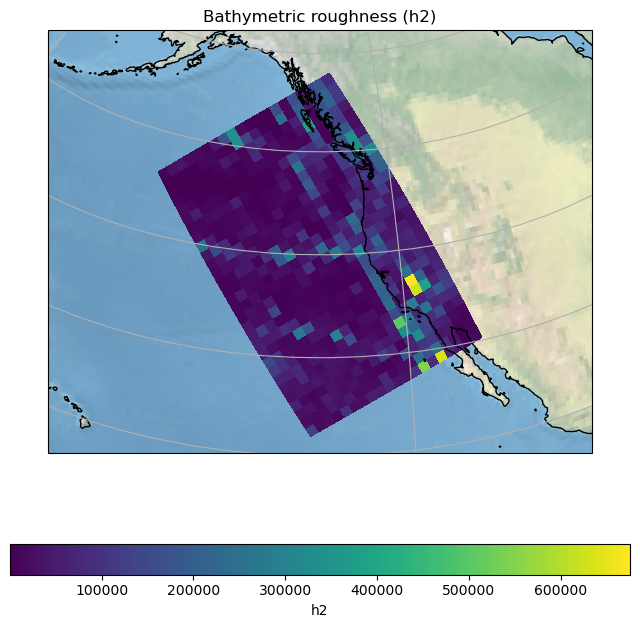

In [33]:
figure

In [34]:
figure.savefig(os.path.join(wrkDir, 'LCC_20x30_h2.png'), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', transparent=False, bbox_inches=None, pad_inches=0.1)